<a href="https://colab.research.google.com/github/weldfenn/PFE/blob/master/3D_point_cloud_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



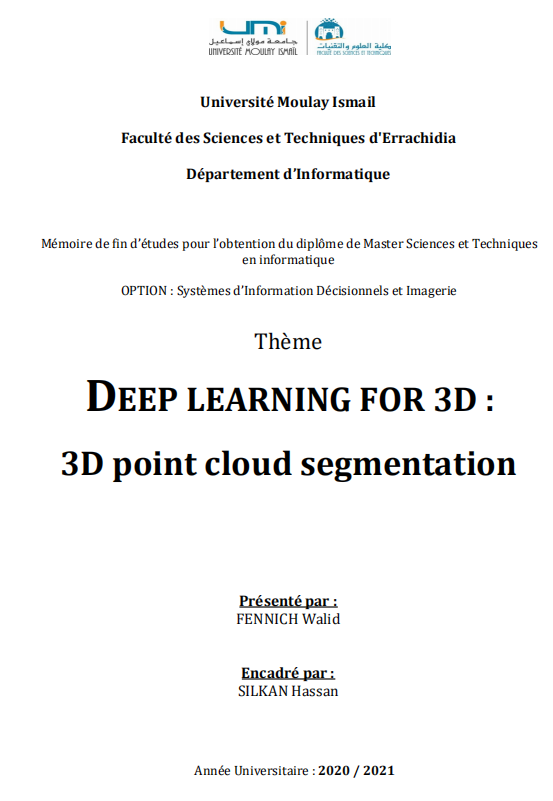


### I.1 Les dépendances et préparation du données

**Importer les bibliothéques nécessaires**

tensorflow , keras ...

In [ ]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Reshape
from keras.layers import Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D
from keras.layers import Lambda, concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pour les visualisations interactives 3D 

import plotly.graph_objs as go
import plotly.express as px

TensorFlow 1.x selected.


Using TensorFlow backend.


**Importer les données**

Le service de stockage Google Drive permet aux fichiers de rester en ligne afin qu'ils puissent être trouvés sur n'importe quel appareil lié à notre compte Google. Il est possible de charger les fichiers de Google Drive dans l'interface de Colobotary. Pour effectuer cette opération nous utiliserons  le code suivant :




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nos données sont dans le fichier
**SEGMENTATION_3D**

In [ ]:
cd drive/My\ Drive/SEGMENTATION_3D/

[Errno 2] No such file or directory: 'drive/My Drive/SEGMENTATION_3D/'
/content/drive/My Drive/SEGMENTATION_3D


In [ ]:
#Les données d'entrainement 

train_points = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

#Les données de validation

valid_points = np.load('val_data.npy')
valid_labels = np.load('val_label.npy')

#La forme des données d'entrainement et test : 

print("Forme d'entraînement: ", train_points.shape)
print("Forme de test : \t", valid_points.shape)



Forme d'entraînement:  (12137, 2048, 3)
Forme de test : 	 (1870, 2048, 3)


Les données sont de forme: (n x nombre de points x coordonnées (x, y, z)).


Ici, nous avons :


*   12137 échantillons  dans notre ensemble d'entrainement
*   1870 échantillons dans notre ensemble de test 

Avec chaque échantillon (objet 3D) á 2048 points , il est représenté par les  coordonnées ( x, y, z ) = 3



##I.2 Visualiser les données 

Nous avons utiliser les deux  bibliothèques matplotlib (figure 1)  et plotly (figure 2) pour visualiser nos données  . 

In [ ]:


def visualize (fichier ):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)
    x = fichier[:, 0]
    y = fichier[:, 1]
    z = fichier[:, 2]
    ax.scatter(x, y, z, marker='.', zdir='z')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

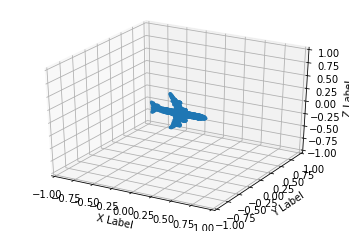

In [ ]:
#Choisir une image du jeu de données 

Test_1 = train_points[7000]

#Afficher la premiére nuage de points a l'aide de la méthode vizualize ()
visualize(Test_1)

In [ ]:
#Utiliser la bibliothéque plotly

# Définir les vecteurs X, Y, Z
X=Test_1[:,0]
Y=Test_1[:,1]
Z=Test_1[:,2]

Data_1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=1))

Data_2 = [Data_1]
L1 = go.Layout(height=500, width=600)

fig = go.Figure(data=Data_2, layout=L1)
fig.show()



# II. Le modèle

In [ ]:
#La fonction utilisée par Les deux transformations .

def Transformation (inputs, Taille_T, Noeuds_MLP=(64, 128, 1024), Noeuds_FC=(512, 256)):

    x = inputs
    for i, Noeuds_Numero in enumerate(Noeuds_MLP):
        #  couche de convolution et de normalisation par lot 
        x = Conv1D(filters=Noeuds_Numero, kernel_size=1, padding='VALID', strides=1, 
                   activation='relu')(x)
        x = BatchNormalization(momentum=0.99)(x)
    #Couche de maxPoling 
    x = GlobalMaxPooling1D()(x)

    for i, Noeuds_Numero in enumerate(Noeuds_FC):
      # couche fully-connected suivi par une couche de normalisation par lot 
        x = Dense(Noeuds_Numero, activation='relu', use_bias=True, bias_initializer=keras.initializers.Zeros())(x)
        x = BatchNormalization(momentum=0.99)(x)

    #Couche fully-connected
    x = Dense(Taille_T * Taille_T,
              weights=[np.zeros([Noeuds_Numero, Taille_T * Taille_T]), np.eye(Taille_T).flatten().astype(np.float32)])(x) 
    Matrice_Transformation = Reshape((Taille_T, Taille_T))(x)
    #La fonction Transformation nous renvoie une matrice de transformation avec une taille (Taille_T X Taille_T)
    return Matrice_Transformation

In [ ]:
# La fonction MLP utilisée par notre MLPs 
def MLP (inputs, Noeuds_MLP):
   
    mlp = []
    x = inputs

    for i, Noeuds_Numero in enumerate(Noeuds_MLP):
        #  couche de convolution et de normalisation par lot                                                                   
        x = Conv1D(filters=Noeuds_Numero, kernel_size=1, padding='VALID', strides=1, 
                   activation='relu')(x)
        x = BatchNormalization(momentum=0.99)(x)
        #x = Dropout(0.2)(x)
        mlp.append(x)
    return mlp

In [ ]:
#Definition de deux fonctions Extend_Dim et Extend_Taille :

'''Extend_Dim :Est une fonction pour étendre la dimension d'un tenseur . 
    (exemple: [1, 2048] à [1, 1, 2048])
 	
    Extend_Taille :Est une fonction pour étendre  la taille d'un tenseur .
     (exemple: [1, 1, 2048] à [1, numemro_points, 2048]) '''


def Extend_Dim(Caracteristique_Globale, Axe):
    return tf.expand_dims(Caracteristique_Globale, Axe)

def Extend_Taille(Caracteristique_Globale, Nombre_Points):
    return tf.tile(Caracteristique_Globale, [1, Nombre_Points, 1])



**L'architecture compléte de notre réseau**

In [ ]:
#L'architecture compléte de notre réseau 
#prend comme deux paramétres  : 
# Param  1 :  Nombre_Points : le nombre de points d'entrée
#Param 2 : Nombre_Classes : le nombre de catégories 

def SEGMENTATION_3D(Nombre_Points, Nombre_Classes):
 
    inputs = Input(shape=(Nombre_Points, 3))


#La premiéme transformation : Transformation d'entrée

    T1 = Transformation (inputs=inputs, Taille_T=3, Noeuds_MLP=(64, 128, 1024), Noeuds_FC=(512, 256))
      
      #Pour aligner les caractéristiques de l’entrée á l’aide de la sortie du réseau T1 .
    Caract_Align1 = keras.layers.dot(inputs=[inputs, T1], axes=2)

#Premier MLP :  MLP(64,128,128) '''
      # Caract_Extr1 : Caractéristique extraite 1
      # Caract_Extr2 : Caractéristique extraite 2
      # Caract_Extr3 : Caractéristique extraite 3

    Caract_Extr1, Caract_Extr2, Caract_Extr3 = MLP(inputs=Caract_Align1, Noeuds_MLP=(64, 128, 128))

#La deuxiéme transformation : Transformation des caractéristiques 
    
    T2 = Transformation(inputs=Caract_Extr3, Taille_T=128, Noeuds_MLP=(256, 1024), Noeuds_FC=(512, 256))
      
      #Pour aligner les caractéristiques de l’entrée á l’aide de la sortie du réseau T2 .
    Caract_Align2 = keras.layers.dot(inputs=[Caract_Extr3, T2], axes=2)
    
#Deuxiéme MLP : MLP(512 , 2048) 
      # Caract_Extr4 : Caractéristique extraite 4
      # Caract_Extr5 : Caractéristique extraite 5

    Caract_Extr4, Caract_Extr5 = MLP(inputs=Caract_Align2, Noeuds_MLP=(512, 2048))
  
#Le MaxPoling pour extraire les caractéristiques globales 
    
    Caracteristique_Globale = GlobalMaxPooling1D()(Caract_Extr5)  

#Utilisation de fonctions : Extend_Dim et Extend_Taille
    
    Caracteristique_Globale_S = Lambda(Extend_Dim, arguments={'Axe': 1})(Caracteristique_Globale)
    Caracteristique_Globale_S = Lambda(Extend_Taille, arguments={'Nombre_Points': Nombre_Points})(Caracteristique_Globale_S)

#La concaténation de caractéristiques Locales et globales 

    #Les caratéristiques Locales : Caract_Extr1,Caract_Extr2,Caract_Extr3,Caract_Extr4,Caract_Extr5
    #Les caractéristiques globales : Caracteristique_Globale_S
    
    Caract_Seg = concatenate(
        [Caract_Extr1, Caract_Extr2, Caract_Extr3, Caract_Align2, Caract_Extr4,
         Caracteristique_Globale_S])
  
#Troisiéme MLP : MLP(256,256, 128 ) 
    
    Caract_Seg1, Caract_Seg2, Caract_Seg3 = MLP (inputs=Caract_Seg, Noeuds_MLP=(256, 256, 128))

#Le résultat de la ségmentation 

    Resultat_Seg = Conv1D(Nombre_Classes, 1, padding='VALID', activation='softmax', bias_regularizer=keras.regularizers.l2(0.001))(Caract_Seg3)

    model = Model(inputs=inputs, outputs=Resultat_Seg)

    return model

# III. La phase d'entrainement

**Les paramètres du modèle**




In [ ]:
#Le nombre d’époques
num_epoches = 15

#La taille du lot
batch_size = 32

# Le nombre de categories (de 1 á 51)
Nombre_Classes = 51 

# Le nombre de points par un nuage de points
Nombre_Points = 2048


# Le taux d'apprentissage
Taux_App = 0.001

# Pour implémenter l'algorithme d’optimisation Adam
opt = keras.optimizers.Adam(learning_rate= Taux_App)

#opt = keras.optimizers.SGD(learning_rate= Taux_App)

#Un encodage á one-hot pour les étiquettes (labels) d'entainement et validation

Train_labels_one_hot = np_utils.to_categorical(train_labels, Nombre_Classes)
Valid_labels_one_hot = np_utils.to_categorical(valid_labels, Nombre_Classes)


**Compilation du** **modéle** 


In [ ]:
model = SEGMENTATION_3D(Nombre_Points=Nombre_Points, Nombre_Classes=Nombre_Classes)
#Summary () pour afficher le contenu de notre modéle 
print(model.summary())
model.compile(optimizer=opt,
              loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 3)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2048, 64)     256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2048, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2048, 128)    8320        batch_normalization_1[0][0]      
____________________________________________________________________________________________

**Autre représentation du MODEL**



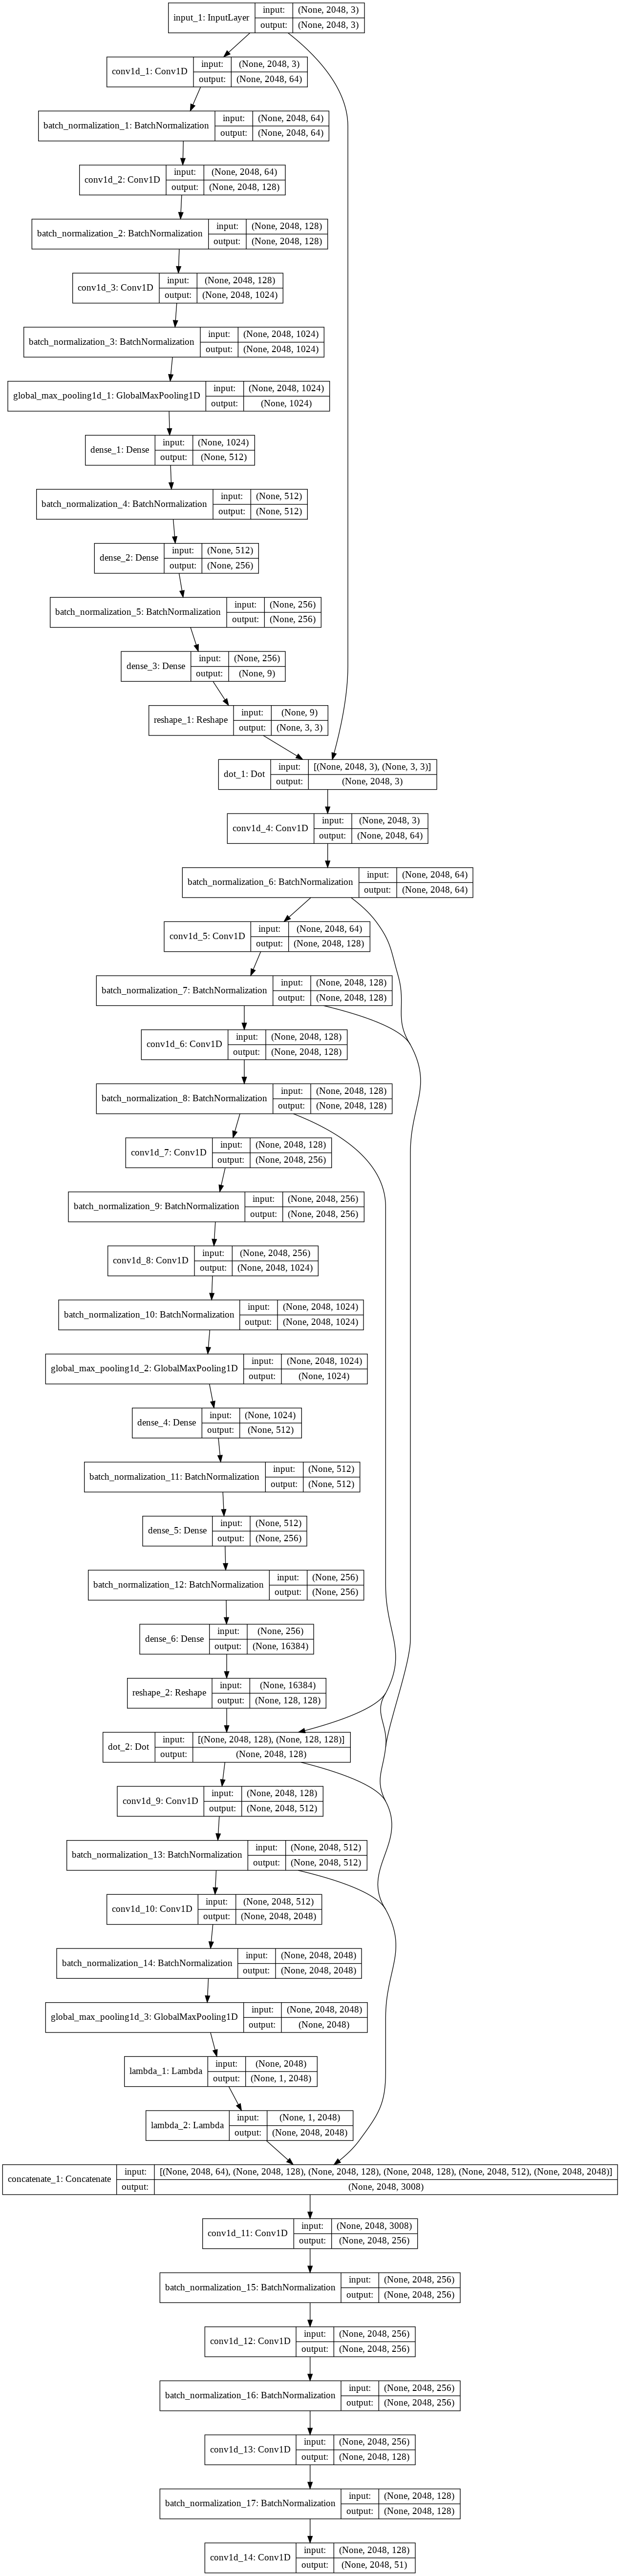

In [ ]:
from keras.utils import plot_model


plot_model(model, show_shapes=True, to_file='model.png')

**Augmentation des données**

Le processus d'augmentation des données consiste á appliquer des transformation sur nos données avant de les utiliser dans la phase d’entraînement tout en maintenant la structure .Pour chaque observation, nous créons plusieurs variations .
Pour cela nous avons défini deux méthodes á l’aide de la bibliothèque NumPy :







> **Rotation_Nuage_Points :**  Pour effectuer une rotation de façon aléatoire les nuages de points, afin d’augmenter le jeu de données . 

>> 1.Input : Nuages de points .





>> 2.Rerturns : Nuages de points tournés .




> **Jitter_Nuage_Points :** Pour disperser (jitter) d’une manière aléatoire les nuages de points, afin de pouvoir mieux distinguer les  points .

>> 1.Input : Nuages de points 

>> 2.Returns : Nuages de points dispersés

In [ ]:
def Rotation_Nuage_Points(batch_data):

    Nuage_Points_Rot = np.zeros(batch_data.shape, dtype=np.float32)
    
    for k in range(batch_data.shape[0]):
        Angle_Rotation = np.random.uniform() * 2 * np.pi
        Valeur_Cos = np.cos(Angle_Rotation)
        Valeur_Sin = np.sin(Angle_Rotation)
        Matrice_Rotation = np.array([[Valeur_Cos, 0, Valeur_Sin],
                                    [0, 1, 0],
                                    [-Valeur_Sin, 0, Valeur_Cos]])
        shape_pc = batch_data[k, ...]
        Nuage_Points_Rot[k, ...] = np.dot(shape_pc.reshape((-1, 3)), Matrice_Rotation)
    return Nuage_Points_Rot


def Jitter_Nuage_Points(batch_data, sigma=0.01, clip=0.05):

    B, N, C = batch_data.shape
    assert(clip > 0)
    Nuage_Points_Jitt = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    Nuage_Points_Jitt += batch_data
    return Nuage_Points_Jitt

Définir la fonction pour diminuer le taux d'apprentissage avec les 20 époques

In [ ]:
def decay_schedule(epoch, Taux_App):
    # decay Taux_App toutes les 20 époques
    if (epoch % 15 == 0) and (epoch != 0):
        Taux_App = Taux_App / 2
    return Taux_App
    
Taux_App_scheduler = LearningRateScheduler(decay_schedule)


**ChekPoint** : Pour enregistrer le modèle Keras et les pondérations du modèle à une certaine fréquence.

In [ ]:
checkpoint = ModelCheckpoint(
    #filepath: pour enregistrer le fichier modèle.
    filepath = "Model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    # pour Enregistrer Weights chaque époque.
    period=1
)

**L'entrainement**

In [ ]:

   
train_points_Rot = Rotation_Nuage_Points(train_points)
Train_points_Jitt = Jitter_Nuage_Points(train_points_Rot)
    
result = model.fit(train_points, Train_labels_one_hot, 
        batch_size=batch_size, epochs=num_epoches,validation_split=0.2, 
        callbacks=[Taux_App_scheduler, checkpoint], shuffle=True, verbose=1)

Train on 9709 samples, validate on 2428 samples
Epoch 1/15
9709/9709 [==============================] - 116s 12ms/step - loss: 0.6550 - accuracy: 0.8145 - val_loss: 6.1080 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 6.10795, saving model to weights_15p_sans_augmentation.h5
Epoch 2/15
9709/9709 [==============================] - 113s 12ms/step - loss: 0.4375 - accuracy: 0.8627 - val_loss: 3.7828 - val_accuracy: 0.2882

Epoch 00002: val_loss improved from 6.10795 to 3.78284, saving model to weights_15p_sans_augmentation.h5
Epoch 3/15
9709/9709 [==============================] - 113s 12ms/step - loss: 0.3652 - accuracy: 0.8806 - val_loss: 3.1643 - val_accuracy: 0.5623

Epoch 00003: val_loss improved from 3.78284 to 3.16430, saving model to weights_15p_sans_augmentation.h5
Epoch 4/15
9709/9709 [==============================] - 113s 12ms/step - loss: 0.3269 - accuracy: 0.8906 - val_loss: 3.0420 - val_accuracy: 0.6021

Epoch 00004: val_loss improved from 3.16430 t

#IV.Évaluer et visualiser

**Test  performance** 

In [ ]:
#Nous chargerons le modéle 
model.load_weights('Model.h5')

In [ ]:
score = model.evaluate(valid_points,Valid_labels_one_hot)
print('Loss:', score[0])
print('Accuracy:', score[1]) 


1870/1870 [==============================] - 9s 5ms/step
Loss: 0.7984966443821708
Accuracy: 0.8404119610786438


**TEST**

Après avoir entraîné notre modèle, nous allons maintenant passer à la phase de prédiction qui consiste á prédire les parties (les étiquettes) d’un nouveau nuage de points. Pour cette phase, nous définissons une fonction appelée prediction (), qui a non seulement une fonction de prédiction, mais peut également visualiser les résultats.
Notre fonction prend un nuage de points de test comme entrée, elle nous renvoie une figure qui illustre le nuage de points d'entrée 3D divisé en plusieurs parties (de 2 á 6 parties).

In [ ]:
def Prediction (Nuage_Ps_Test) :
 #Les Prédictions
  pred = model.predict(Nuage_Ps_Test)
  pred = np.squeeze(pred)
  Nuage_Ps_Test = np.squeeze(Nuage_Ps_Test)
  pred = pred.tolist()

  indice = []
  for i in range(Nuage_Ps_Test.shape[0]):
      indice.append(np.argmax(pred[i]))
  indice = set(indice)
  dict={}
  for c, i in enumerate(indice):
    dict[i] = c 

  #6 couleurs 
  
  couleurs = ['b', 'c', 'g', 'r', 'y', 'm']
 

  m= ['o', 'v', '<', '>', '^', 'v']
#C : une liste  renvoie un couleur pour chaque  points des 2048 points  exemple : ['b', 'b', 'b', 'b', 'b', 'g', 'b', 'b ..... ]
  c = []
  for i in range(Nuage_Ps_Test.shape[0]):
    xs = Nuage_Ps_Test[i,0]
    ys = Nuage_Ps_Test[i,1]
    zs = Nuage_Ps_Test[i,2]
       
    indice2 = dict[np.argmax(pred[i])]
    c.append(couleurs[indice2])

  fig = px.scatter_3d(Nuage_Ps_Test, x=Nuage_Ps_Test[:,0], y=Nuage_Ps_Test[:,1], z=Nuage_Ps_Test[:,2], color=c)

  return fig.show() 


**FAIRE un TEST**

In [ ]:
Nuage_P_Test = valid_points[700:701,:,:]

Prediction (Nuage_P_Test)

In [ ]:
Nuage_P2 = valid_points[957:958,:,:]
Prediction (Nuage_P2)